In [82]:
'''
Title:       Optimale Steuerung und Regelung:
Subttitle:   3. Aufgabe
Author:      Stefan Kaufmann
MaNr.        51867606
Date:        06.06.2023
'''

'\nTitle:       Optimale Steuerung und Regelung:\nSubttitle:   3. Aufgabe\nAuthor:      Stefan Kaufmann\nMaNr.        51867606\nDate:        06.06.2023\n'

# Optimale Steuerung und Regelung
## 3. Randwertproblem
### Stefan Kaufmann - 51867606

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
import sympy as sym

import libop as libop

# 1. Model    
    
$
\dot{X}(t) = f (x(t),u(t)) = 
\begin{bmatrix}
\omega (t) \\
\frac{mga sin{\Theta (t) -d \omega(t) +mau(t) cos{\Theta (t)}}}{J+ma^{2}} \\
v(t) \\
u(t)
\end{bmatrix}
$

In [84]:
# System dynamic
def System_dynamic(x,u):
    dx = np.zeros(nx)
    dx[0] = x[1]
    dx[1] = (m*g*a*np.sin(x[0])+m*a*np.cos(x[0])*u-d*x[1])/(J+m*a**2) 
    dx[2] = x[3]
    dx[3] = u

    return dx

# 2. Zwei-Punkt Randwertproblem Allgemein 

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.27e-04       0.00e+00          50              0       
Solved in 1 iterations, number of nodes 50. 
Maximum relative residual: 1.27e-04 
Maximum boundary residual: 0.00e+00


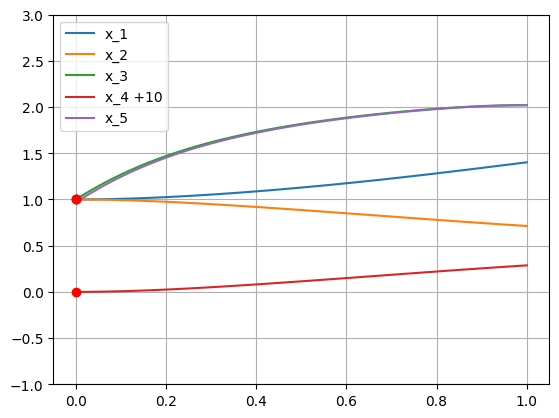

In [85]:
t = np.linspace(0,1,50)

def System(t,x):
    dx = np.zeros_like(x)
       
    dx[0] = x[0]*(x[2]-x[0])/(2*x[1])
    dx[1] = -0.5*(x[2]-x[0])
    dx[2] = (0.9-1000*(x[2]-x[4])-0.5*x[2]*(x[2]-x[0]))/x[3]
    dx[3] = 0.5*(x[2]-x[0])
    dx[4] = -100*(x[4]-x[2])        
    
    return dx

def bc(ya,yb):
    
    return [ya[0]-1,ya[1]-1,ya[2]-1,ya[3]+10, yb[4]-yb[2] ] 

y = np.zeros((5,len(t))) 

y0 = np.zeros((5,len(t))) 

# Boundary conditions
ya = y0[0,:]    # Startbedingung
yb = y0[-1,:]   # Endbedingung

# # Startlösung 
for i in range(0,len(t)):
    y0[0,i] = 1
    y0[1,i] = 1
    y0[2,i] = -4.5*(t[i]**2) +8.91*t[i] + 1
    y0[3,i] = -10
    y0[4,i] = -4.5*(t[i]**2)+9*t[i] + 0.91              





res = solve_bvp(System, bc, t, y0, verbose = 2)

plt.plot(res.x,res.y[0],label = 'x_1')
plt.plot(res.x,res.y[1],label = 'x_2')
plt.plot(res.x,res.y[2],label = 'x_3')
plt.plot(res.x,res.y[3]+10,label = 'x_4 +10')
plt.plot(res.x,res.y[4],label = 'x_5')
plt.grid()
plt.legend()
plt.ylim((-1,3))

# Plotten der Randwerte
plt.plot(np.zeros(4), [1,1,1,0], 'ro')

# 3. Problemsetup 

## 3.1 Aufstellen der Hamilton Funktion
$
H(x,u,\lambda,u) = l(x,u,t) + \lambda^{T} f(x,u,t) \\
H(x,u,\lambda,u) = 1 + \frac{1}{2} (x^{T}Qx + u^{T}Ru)  + \lambda^{T} f(x,u,t)   
$    
    
## 3.2 Steuerungsgleichung
$
H_{u} = 0 = Ru + \lambda_{4} + \lambda_{2} \frac{ma cos(\theta)}{J+ma^{2}} \\
u = - \frac{\lambda_{4}}{R}  - \lambda_{2} \frac{ma cos(\theta)}{R(J+ma^{2})}
$   


## 3.3 Kanonische Gleichung   
$
\dot{x} = f(x,\lambda) = H_{\lambda}  \\
\dot{\lambda} = -H_{x}
$

In [86]:
theta, omega, s, v, l1, l2, l3, l4, m,a,g,d,J,u, R, q1,q2,q3,q4, P , J_= sym.symbols("theta omega s v lambda_1 lambda_2  lambda_3  lambda_4  m a g d J u R q1 q2 q3 q4 P J_quer")

Q = sym.Matrix([[q1,0,0,0,],[0,q2,0,0],[0,0,q3,0],[0,0,0,q4]])
x = sym.Matrix([theta,omega,s,v])
l = sym.Matrix([l1,l2,l3,l4])
dx = sym.Matrix([omega,
                 P*g*sym.sin(theta)+ P*sym.cos(theta)*u + -d*omega /J_
                 ,v
                 ,u])
#display(dx)

u_ = -l4/R -l2*sym.cos(theta)*P/R
#display(u_)

# Hamiltonfunktion
H =  l.T@dx  +(x.T@Q@x )/2
H[0] +=(R*u**2)/2 +1
display(H)

Matrix([[R*u**2/2 + lambda_1*omega + lambda_2*(P*g*sin(theta) + P*u*cos(theta) - d*omega/J_quer) + lambda_3*v + lambda_4*u + omega**2*q2/2 + q1*theta**2/2 + q3*s**2/2 + q4*v**2/2 + 1]])

In [87]:
# Berechnung der Ableitungen
dx_ =  H.jacobian(l)
dl =  -H.jacobian(x)


display(sym.simplify(dx_.T))
display(sym.simplify(dl.T))


Matrix([
[                                                    omega],
[(J_quer*P*(g*sin(theta) + u*cos(theta)) - d*omega)/J_quer],
[                                                        v],
[                                                        u]])

Matrix([
[-P*lambda_2*(g*cos(theta) - u*sin(theta)) - q1*theta],
[            -lambda_1 - omega*q2 + d*lambda_2/J_quer],
[                                               -q3*s],
[                                    -lambda_3 - q4*v]])

## 3.4 Numerische Lösung

In [88]:
global nx, nu, nxu, N, t, Ta, S, M, Q, R


t_end = 4
N = 8
t = np.linspace(0,t_end,N)

# Anzahl an Zuständen und Eingängen
nx = 4
nu = 1
nxu = nx+nu

M = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1]])

Q = np.eye(4)
S = np.diag([0,0,5,0])
R = 0.1

# Parameter
global J,a,m,d,g

J = 0.0361  # kgm²
a = 0.42    # m
m = 0.3553  # kg
d = 0.005   # Nms
g = 9.81    # m/s²

In [105]:
x0 = [np.pi, 0, 0, 0]
xN = [0,0 ,0,0]
umax = 12
umin = -12

In [106]:
def Pendel_dynamic(t,x):
    # x = [phi, omega, x, v, l1, l2, l3, l4]
    dx = np.zeros_like(x)      
    
    J_quer = J +m*a**2
    P = m*a/(J_quer)
    u = (-x[5]*np.cos(x[0])*m*a/J_quer -x[7])/R

    dx[0] = x[1]
    dx[1] = (m*g*a*np.sin(x[0])+m*a*np.cos(x[0])*u-d*x[1])/(J+m*a**2) 
    dx[2] = x[3]
    dx[3] = u
     
    dx[4] =  -m*a*x[5]*(g*np.cos(x[0])-u*np.sin(x[0])) /J_quer
    dx[5] = -x[4] + d*x[5]/J_quer
    dx[6] =  0
    dx[7] = -x[6] 

    dx[4:] -= Q@x[:nx]    # = -dl/dx

    return dx

In [107]:
# Boundary Conditions

def bc(ya,yb):
    ''' define the boundary conditions '''
    # ya are the initial values
    # yb are the final values
    # each entry of the return array will be set to zero
    bcon = np.zeros(nx*2)
    bcon[:nx]  = ya[:nx] - x0
    bcon[4] = yb[0] - xN[0] 
    bcon[5] = yb[1] - xN[1] 
    bcon[6] = yb[6] - S[2,2]*yb[2]
    bcon[7] = yb[3] - xN[3]  
    return bcon 

In [96]:
# Lösung 
y0 = np.ones((nx*2,N))

#y0[:nx*2,:] = x_cut
#y0[-1,:] =  u_cut

# Solve the system.
sol_unb = solve_bvp(Pendel_dynamic, bc, t, y0, verbose = 2, tol=1e-9, bc_tol = 1e-6, max_nodes=100)


   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.01e+01       2.31e+00           8             14       
       2          2.40e+00       7.78e-12          22             42       
       3          1.25e-01       5.10e-14          64            (126)     
Number of nodes is exceeded after iteration 3. 
Maximum relative residual: 1.25e-01 
Maximum boundary residual: 5.10e-14


## Lösung Beschränktes Problem

In [108]:
# Eingang
def Eingang(x,umax=12,umin=-12):
    u = np.zeros(len(x[0]))

    for i in range(0,len(u)):
        u[i] = -x[5,i]*m*a*np.cos(x[0,i])/(R*(J+m*a**2)) - x[7,i]/R
        u[i] = min(u[i],umax) 
        u[i] = max(u[i],umin)
    return u

In [109]:
def Pendel_dynamic_beschraenkt(t,x):
    # x = [phi, omega, x, v, l1, l2, l3, l4]
    dx = np.zeros_like(x)      
    
    J_quer = J +m*a**2
    P = m*a/(J_quer)
    
    u = Eingang(x,umax=13)  #(-x[5]*np.cos(x[0])*m*a/J_quer -x[7])/R
    #u = np.clip(u,umin,umax)
    
    
    dx[0] = x[1]
    dx[1] = (m*g*a*np.sin(x[0])+m*a*np.cos(x[0])*u-d*x[1])/(J+m*a**2) 
    dx[2] = x[3]
    dx[3] = u
    #print(Eingang(x))
        
    dx[4] =  -m*a*x[5]*(g*np.cos(x[0])-u*np.sin(x[0])) /J_quer
    dx[5] = -x[4] + d*x[5]/J_quer
    dx[6] =  0
    dx[7] = -x[6] 

    dx[4:] -= Q@x[:nx]    # = -dl/dx

    return dx

In [110]:
# Lösung 
#y0_unb = sol_unb.y
#t_unb =  sol_unb.x

t_unb = sol.x 
y0_unb = sol.y


# Solve the system.
sol = solve_bvp(Pendel_dynamic_beschraenkt, bc, t_unb, y0_unb, verbose = 2, tol=1e-6, bc_tol = 1e-3, max_nodes=100000)

U = Eingang(sol.y)

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.36e-04       2.81e-25         32215            3       
       2          3.15e-05       2.54e-25         32218            2       
       3          1.58e-05       6.94e-18         32220            2       
       4          7.87e-06       3.44e-27         32222            2       
       5          3.95e-06       1.67e-27         32224            2       
       6          1.96e-06       8.84e-28         32226            1       
       7          9.93e-07       6.94e-18         32227            0       
Solved in 7 iterations, number of nodes 32227. 
Maximum relative residual: 9.93e-07 
Maximum boundary residual: 6.94e-18


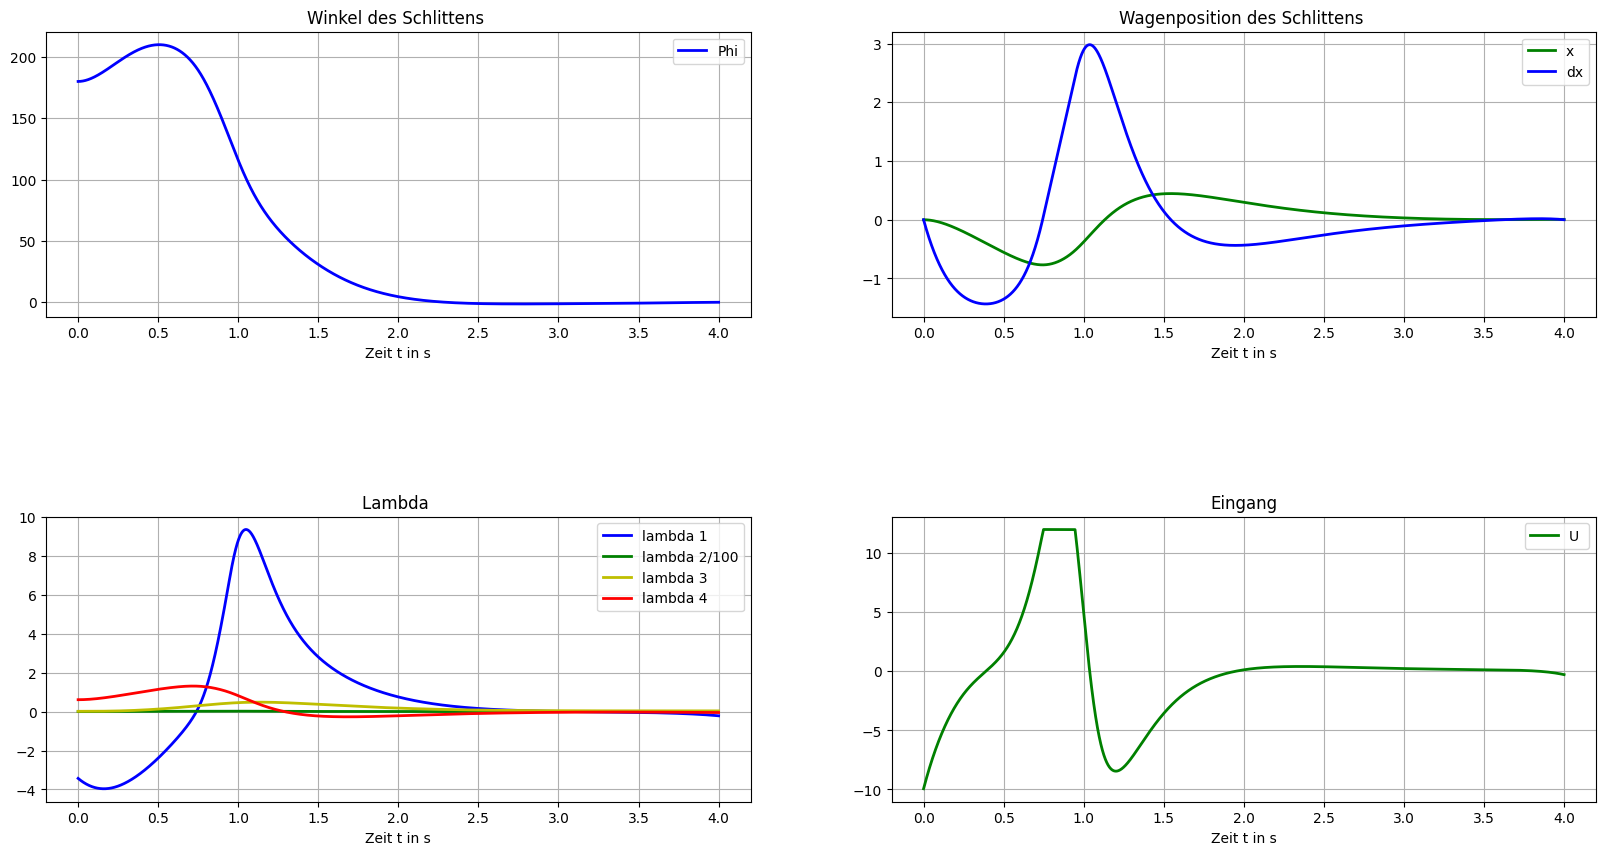

In [111]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
fig.subplots_adjust(hspace=0.7)
fig.set_size_inches(20,10)

#ax1.plot(sol.x,sol.y[1]*180/np.pi,'g', linewidth ='2', label = 'Omega')
ax1.plot(sol.x,sol.y[0]*180/np.pi,'b', linewidth ='2', label = 'Phi')
ax1.set_xlabel('Zeit t in s')
ax1.legend(loc='best')
ax1.set_title('Winkel des Schlittens ')   
ax1.grid()

ax2.plot(sol.x,sol.y[2],'g', linewidth ='2', label = 'x ')
ax2.plot(sol.x,sol.y[3],'b', linewidth ='2', label = 'dx')
ax2.set_xlabel('Zeit t in s')
ax2.legend(loc='best')
ax2.set_title('Wagenposition des Schlittens ')   
ax2.grid()

ax3.plot(sol.x,sol.y[4],'b', linewidth ='2', label = 'lambda 1')
ax3.plot(sol.x,sol.y[5]/100,'g', linewidth ='2', label = 'lambda 2/100')
ax3.plot(sol.x,sol.y[6],'y', linewidth ='2', label = 'lambda 3')
ax3.plot(sol.x,sol.y[7],'r', linewidth ='2', label = 'lambda 4')
ax3.set_xlabel('Zeit t in s')
ax3.legend(loc='best')
ax3.set_title('Lambda ')   
ax3.grid()



ax4.plot(sol.x,U,'g', linewidth ='2', label = 'U ')
ax4.set_xlabel('Zeit t in s')
ax4.legend(loc='best')
ax4.set_title('Eingang')   
ax4.grid()




# Überprüfung

In [112]:
import control as ct
import control.optimal as obc


def system_update(t, x, u,params):
    # Return the derivative of the state
    return System_dynamic(x,u)

def system_output(t, x, u,params):
    return x

# Define the vehicle steering dynamics as an input/output system
Pendel = ct.NonlinearIOSystem(
    system_update, system_output, states=4, name='Pendel',
    inputs=('u'), outputs=('phi','omega','x','dx'))

#timepts = np.linspace(0,t_end, 500)
#U_inter = np.interp(timepts, sol.x,U)
input = U ;  timepts = sol.x


resp = ct.input_output_response(
    Pendel, timepts, input, x0,
    t_eval=timepts)
t_sim, y_sim, u_sim = resp.time, resp.outputs, resp.inputs


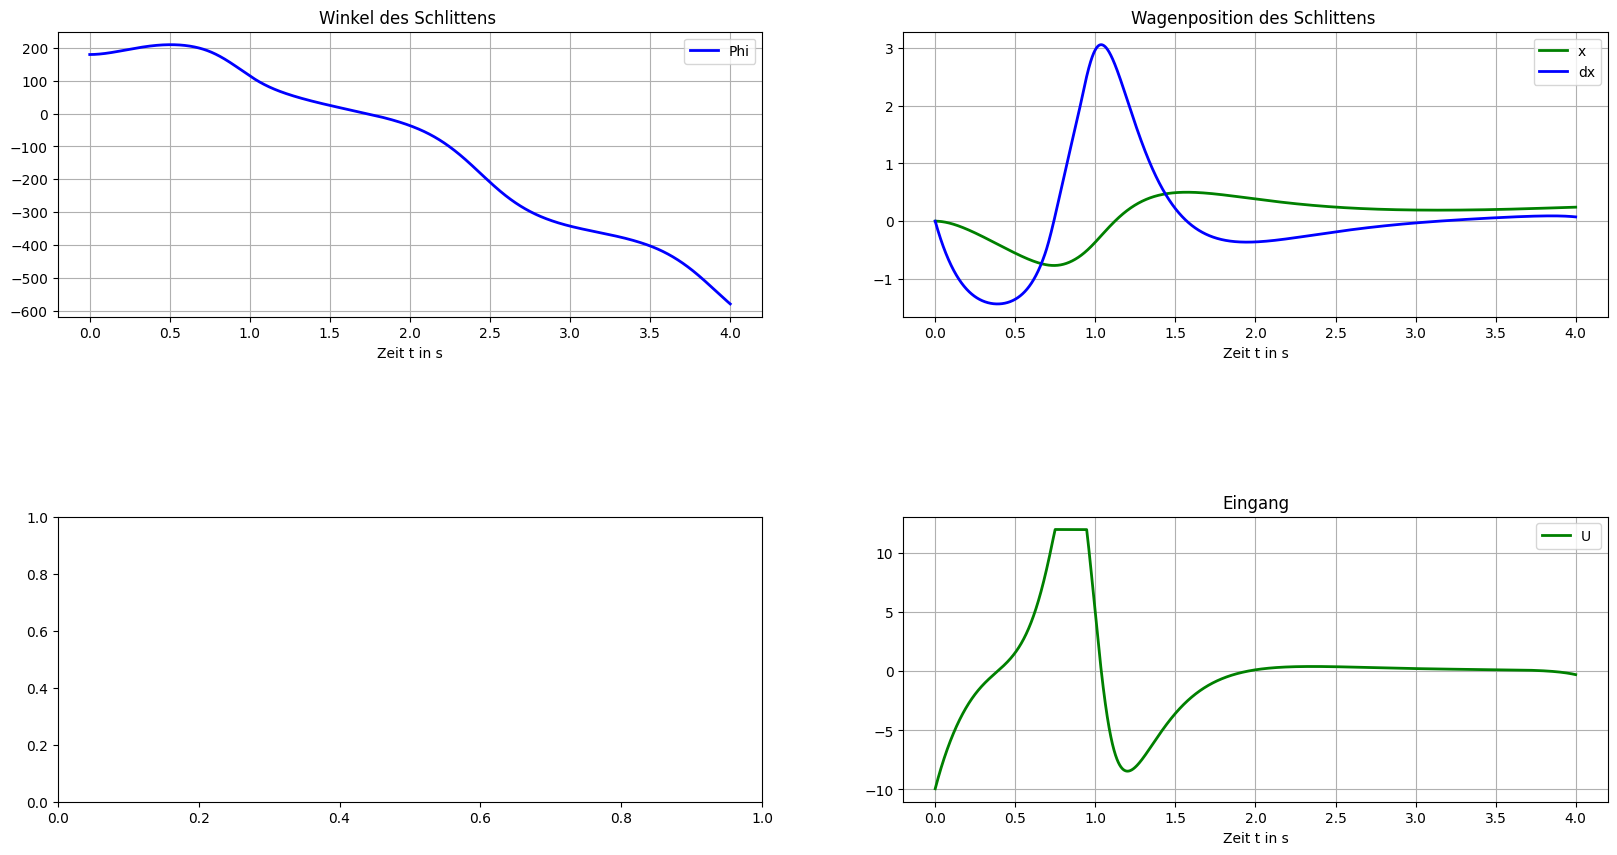

In [113]:
fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2)
fig.subplots_adjust(hspace=0.7)
fig.set_size_inches(20,10)

#ax1.plot(t_sim,y_sim[1]*180/np.pi,'g', linewidth ='2', label = 'Omega')
ax1.plot(t_sim,y_sim[0]*180/np.pi,'b', linewidth ='2', label = 'Phi')
ax1.set_xlabel('Zeit t in s')
ax1.legend(loc='best')
ax1.set_title('Winkel des Schlittens ')   
ax1.grid()

ax2.plot(t_sim,y_sim[2],'g', linewidth ='2', label = 'x ')
ax2.plot(t_sim,y_sim[3],'b', linewidth ='2', label = 'dx')
ax2.set_xlabel('Zeit t in s')
ax2.legend(loc='best')
ax2.set_title('Wagenposition des Schlittens ')   
ax2.grid()



ax4.plot(t_sim, u_sim[0],'g', linewidth ='2', label = 'U ')
ax4.set_xlabel('Zeit t in s')
ax4.legend(loc='best')
ax4.set_title('Eingang')   
ax4.grid()




In [114]:
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Parameter des Cartpole-Systems
L = 1.0  # Länge des Pendels
H = 0.5  # Höhe des Wagens

# Funktion zur Animation des Cartpole-Systems
def animate_cartpole(t, states):
    # Umwandlung der Zustände in Wagen- und Pendelpositionen
    x = states[:, 2]
    theta = states[:, 0]

    # Berechnung der Positionen des Pendels
    x_pend = x + L * np.sin(theta)
    y_pend = H + L * np.cos(theta)

    # Erstellung des Animationsfensters
    fig, ax = plt.subplots()
    ax.set_xlim(min(x) - 1, max(x) + 1)
    ax.set_ylim(-0.7, H + L + 1)
    ax.set_aspect('equal')
    ax.grid()    
    cart = patches.Rectangle((x[0]-0.5, 0), 1, H,facecolor=(0, 1, 0, 0.5))
    ax.add_patch(cart)
    pendulum, = plt.plot([], [], lw=2)  # Pendel
    trace, = plt.plot([], [], 'k--')  # Spur der Pendelspitze
    
    def update(frame):
        # Aktualisierung der Positionen von Wagen und Pendel        
        cart.set_x(x[frame] - 0.5)        
        pendulum.set_data([x[frame], x_pend[frame]], [H, y_pend[frame]])
        trace.set_data(x_pend[:frame], y_pend[:frame])
        return cart, pendulum, trace

    # Animation erstellen
    anim = FuncAnimation(fig, update, frames=len(t), interval=50, blit=True)

    # HTML-Video generieren und anzeigen
    html_video = anim.to_jshtml()
    plt.close()
    return HTML(html_video)

# Beispielaufruf der Funktion
Nt = 100
t_inter = np.linspace(0, 4, Nt)  # Zeitpunkte
states = np.zeros((len(t_inter), nx))  # Beispielzustände (phi, omega, x, v)
for i in range(0,nx):
    states[:,i] = np.interp(t_inter, t_sim,y_sim[i])
animate_cartpole(t_inter, states)

